# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

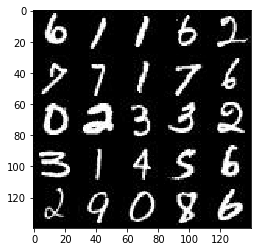

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

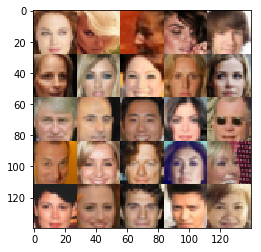

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name = 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return real_inputs, z_inputs, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2

    with tf.variable_scope('discriminator', reuse = reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d(x2, 256, 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha * x3, x3)

        flat = tf.reshape(x3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2

    with tf.variable_scope('generator', reuse = not is_train):

        x1 = tf.layers.dense(z, 2 * 2 * 512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding = 'valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 2, padding = 'same')
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]

    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape

    real_input, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)

    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                z_batch = np.random.uniform(-1, 1, size = (batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict = {real_input: batch_images, z_input: z_batch, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {z_input: z_batch, lr: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.1060... Generator Loss: 0.5515
Epoch 1/2... Discriminator Loss: 1.2279... Generator Loss: 2.1908
Epoch 1/2... Discriminator Loss: 0.3034... Generator Loss: 1.8687
Epoch 1/2... Discriminator Loss: 1.1765... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 0.0036... Generator Loss: 7.7798
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.3701
Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 7.8948
Epoch 1/2... Discriminator Loss: 0.0506... Generator Loss: 4.3187
Epoch 1/2... Discriminator Loss: 0.0123... Generator Loss: 5.4662
Epoch 1/2... Discriminator Loss: 0.0046... Generator Loss: 6.6326


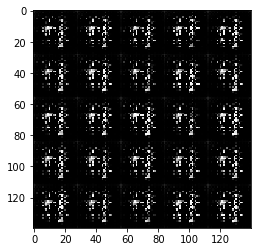

Epoch 1/2... Discriminator Loss: 0.2047... Generator Loss: 7.4768
Epoch 1/2... Discriminator Loss: 0.1514... Generator Loss: 5.9983
Epoch 1/2... Discriminator Loss: 0.2666... Generator Loss: 3.1023
Epoch 1/2... Discriminator Loss: 0.4021... Generator Loss: 3.1456
Epoch 1/2... Discriminator Loss: 0.1471... Generator Loss: 2.6152
Epoch 1/2... Discriminator Loss: 2.1213... Generator Loss: 8.8453
Epoch 1/2... Discriminator Loss: 0.5358... Generator Loss: 2.3975
Epoch 1/2... Discriminator Loss: 0.4270... Generator Loss: 1.7598
Epoch 1/2... Discriminator Loss: 0.4494... Generator Loss: 2.1732
Epoch 1/2... Discriminator Loss: 0.6170... Generator Loss: 5.4279


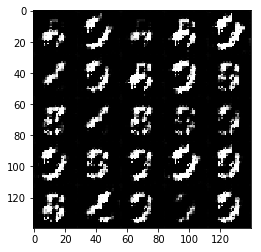

Epoch 1/2... Discriminator Loss: 0.1904... Generator Loss: 3.3225
Epoch 1/2... Discriminator Loss: 0.2284... Generator Loss: 3.8577
Epoch 1/2... Discriminator Loss: 0.2242... Generator Loss: 3.0781
Epoch 1/2... Discriminator Loss: 0.3131... Generator Loss: 2.0715
Epoch 1/2... Discriminator Loss: 0.3613... Generator Loss: 2.5273
Epoch 1/2... Discriminator Loss: 0.2580... Generator Loss: 3.3407
Epoch 1/2... Discriminator Loss: 0.3667... Generator Loss: 5.1258
Epoch 1/2... Discriminator Loss: 0.7248... Generator Loss: 1.6830
Epoch 1/2... Discriminator Loss: 0.3435... Generator Loss: 1.9156
Epoch 1/2... Discriminator Loss: 0.1475... Generator Loss: 3.4305


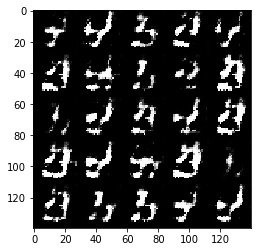

Epoch 1/2... Discriminator Loss: 0.3697... Generator Loss: 3.4547
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 3.2904
Epoch 1/2... Discriminator Loss: 0.3471... Generator Loss: 2.6084
Epoch 1/2... Discriminator Loss: 0.2783... Generator Loss: 4.0331
Epoch 1/2... Discriminator Loss: 0.2598... Generator Loss: 6.5613
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 1.8515
Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 2.7360
Epoch 1/2... Discriminator Loss: 0.4634... Generator Loss: 1.8683
Epoch 1/2... Discriminator Loss: 0.4271... Generator Loss: 1.5803
Epoch 1/2... Discriminator Loss: 0.2640... Generator Loss: 2.5739


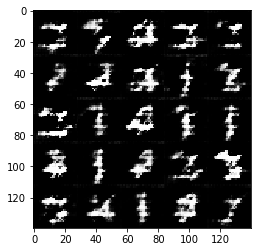

Epoch 1/2... Discriminator Loss: 1.0372... Generator Loss: 1.0534
Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 0.8812
Epoch 1/2... Discriminator Loss: 0.3606... Generator Loss: 2.6247
Epoch 1/2... Discriminator Loss: 1.1794... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 0.7256... Generator Loss: 1.0627
Epoch 1/2... Discriminator Loss: 1.0164... Generator Loss: 1.0550
Epoch 1/2... Discriminator Loss: 0.8761... Generator Loss: 0.9615
Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 1.0725
Epoch 1/2... Discriminator Loss: 0.6625... Generator Loss: 2.1093
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 0.7628


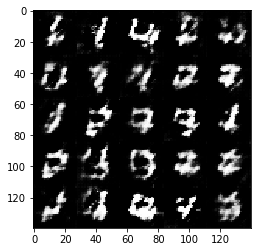

Epoch 1/2... Discriminator Loss: 0.7543... Generator Loss: 2.9163
Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 1.2692
Epoch 1/2... Discriminator Loss: 0.7948... Generator Loss: 1.1160
Epoch 1/2... Discriminator Loss: 0.7308... Generator Loss: 1.3415
Epoch 1/2... Discriminator Loss: 0.7076... Generator Loss: 2.2556
Epoch 1/2... Discriminator Loss: 1.1715... Generator Loss: 0.7171
Epoch 1/2... Discriminator Loss: 0.8178... Generator Loss: 2.1262
Epoch 1/2... Discriminator Loss: 0.7012... Generator Loss: 2.0226
Epoch 1/2... Discriminator Loss: 0.5382... Generator Loss: 1.9491
Epoch 1/2... Discriminator Loss: 0.7606... Generator Loss: 2.0824


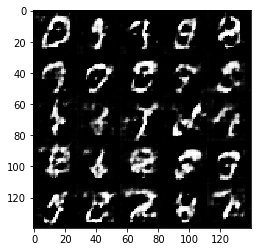

Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 1.2024
Epoch 1/2... Discriminator Loss: 1.8938... Generator Loss: 0.2430
Epoch 1/2... Discriminator Loss: 0.7548... Generator Loss: 0.9529
Epoch 1/2... Discriminator Loss: 0.5729... Generator Loss: 2.2496
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 0.7632
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 1.1934
Epoch 1/2... Discriminator Loss: 0.9853... Generator Loss: 1.0090
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 3.3734
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 0.9748
Epoch 1/2... Discriminator Loss: 0.6872... Generator Loss: 1.7043


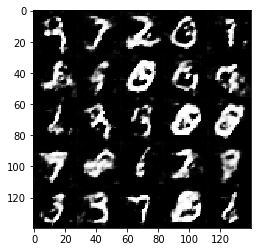

Epoch 1/2... Discriminator Loss: 0.4856... Generator Loss: 2.0636
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 1.0139
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 0.5663... Generator Loss: 1.5931
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.4650
Epoch 1/2... Discriminator Loss: 0.8721... Generator Loss: 0.9841
Epoch 1/2... Discriminator Loss: 1.7851... Generator Loss: 4.0082
Epoch 1/2... Discriminator Loss: 0.9083... Generator Loss: 1.1080
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 1.3629
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 3.6569


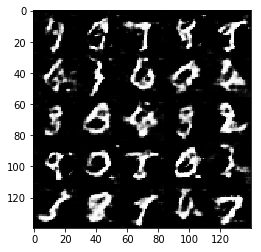

Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 0.5478
Epoch 1/2... Discriminator Loss: 0.9058... Generator Loss: 0.9350
Epoch 1/2... Discriminator Loss: 0.6330... Generator Loss: 1.5923
Epoch 1/2... Discriminator Loss: 0.7549... Generator Loss: 1.0843
Epoch 1/2... Discriminator Loss: 0.7488... Generator Loss: 1.1446
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 1.4024
Epoch 1/2... Discriminator Loss: 1.3418... Generator Loss: 0.4669
Epoch 1/2... Discriminator Loss: 0.7073... Generator Loss: 1.0650
Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 3.2036
Epoch 1/2... Discriminator Loss: 1.6314... Generator Loss: 0.3744


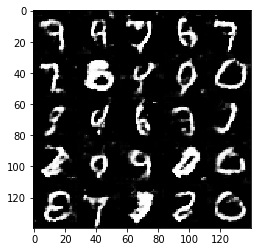

Epoch 1/2... Discriminator Loss: 0.8973... Generator Loss: 1.2704
Epoch 1/2... Discriminator Loss: 0.7417... Generator Loss: 2.0962
Epoch 1/2... Discriminator Loss: 1.4070... Generator Loss: 3.6875
Epoch 2/2... Discriminator Loss: 0.6797... Generator Loss: 1.4341
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 1.9011
Epoch 2/2... Discriminator Loss: 1.0072... Generator Loss: 0.7519
Epoch 2/2... Discriminator Loss: 1.8340... Generator Loss: 0.2901
Epoch 2/2... Discriminator Loss: 0.7966... Generator Loss: 1.2528
Epoch 2/2... Discriminator Loss: 1.9665... Generator Loss: 0.2418
Epoch 2/2... Discriminator Loss: 1.9132... Generator Loss: 0.2556


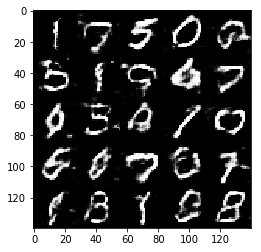

Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 2.1285
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.6030
Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 1.2713
Epoch 2/2... Discriminator Loss: 1.4202... Generator Loss: 0.4715
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 0.9321
Epoch 2/2... Discriminator Loss: 1.0689... Generator Loss: 0.6639
Epoch 2/2... Discriminator Loss: 1.7729... Generator Loss: 3.3047
Epoch 2/2... Discriminator Loss: 0.8550... Generator Loss: 1.9347
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 1.9983
Epoch 2/2... Discriminator Loss: 1.8179... Generator Loss: 2.8511


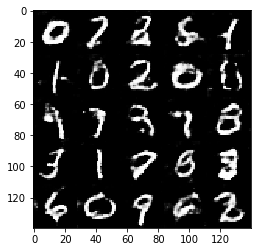

Epoch 2/2... Discriminator Loss: 0.8771... Generator Loss: 1.5508
Epoch 2/2... Discriminator Loss: 1.1488... Generator Loss: 0.8325
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 1.0818
Epoch 2/2... Discriminator Loss: 0.8771... Generator Loss: 0.9788
Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 0.6290
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 0.4445
Epoch 2/2... Discriminator Loss: 1.1973... Generator Loss: 1.8101
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 0.6019


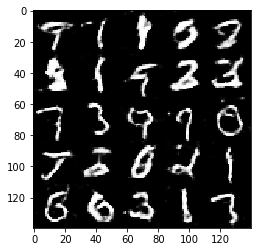

Epoch 2/2... Discriminator Loss: 0.8965... Generator Loss: 1.1976
Epoch 2/2... Discriminator Loss: 0.7379... Generator Loss: 1.7554
Epoch 2/2... Discriminator Loss: 0.8235... Generator Loss: 1.0553
Epoch 2/2... Discriminator Loss: 0.8876... Generator Loss: 1.2278
Epoch 2/2... Discriminator Loss: 0.6927... Generator Loss: 1.2282
Epoch 2/2... Discriminator Loss: 1.5246... Generator Loss: 3.3034
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 0.6013
Epoch 2/2... Discriminator Loss: 1.9912... Generator Loss: 0.2262
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 1.3051
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.5551


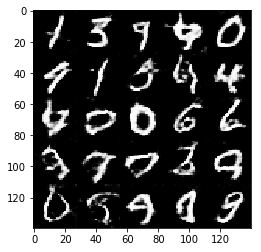

Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 1.1989
Epoch 2/2... Discriminator Loss: 0.9828... Generator Loss: 1.0683
Epoch 2/2... Discriminator Loss: 1.5337... Generator Loss: 0.3747
Epoch 2/2... Discriminator Loss: 0.9621... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 0.5452
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 0.7559
Epoch 2/2... Discriminator Loss: 1.2381... Generator Loss: 0.5334
Epoch 2/2... Discriminator Loss: 0.5609... Generator Loss: 1.3232
Epoch 2/2... Discriminator Loss: 1.2765... Generator Loss: 0.4870


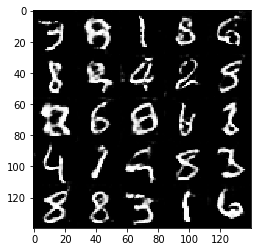

Epoch 2/2... Discriminator Loss: 0.8165... Generator Loss: 1.6584
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 0.6380
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 2.2386
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 0.4797
Epoch 2/2... Discriminator Loss: 1.4724... Generator Loss: 0.4364
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 1.1619
Epoch 2/2... Discriminator Loss: 1.2008... Generator Loss: 0.5372
Epoch 2/2... Discriminator Loss: 1.4406... Generator Loss: 0.3832
Epoch 2/2... Discriminator Loss: 0.8586... Generator Loss: 0.9147


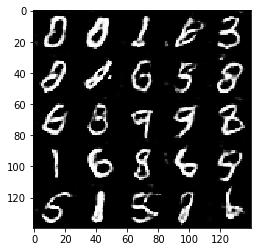

Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 0.6125
Epoch 2/2... Discriminator Loss: 1.2537... Generator Loss: 0.5857
Epoch 2/2... Discriminator Loss: 0.7580... Generator Loss: 1.0077
Epoch 2/2... Discriminator Loss: 1.1098... Generator Loss: 0.6165
Epoch 2/2... Discriminator Loss: 0.9771... Generator Loss: 1.7023
Epoch 2/2... Discriminator Loss: 0.6754... Generator Loss: 2.4489
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 2.2278
Epoch 2/2... Discriminator Loss: 1.2739... Generator Loss: 0.4955
Epoch 2/2... Discriminator Loss: 0.6792... Generator Loss: 1.4507
Epoch 2/2... Discriminator Loss: 1.0643... Generator Loss: 2.7722


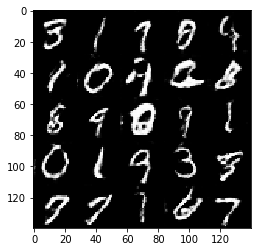

Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.3483
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 0.3451... Generator Loss: 2.2810
Epoch 2/2... Discriminator Loss: 0.8534... Generator Loss: 1.0337
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.4440
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 0.8343
Epoch 2/2... Discriminator Loss: 0.8743... Generator Loss: 0.9857
Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 1.0723
Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 0.7282
Epoch 2/2... Discriminator Loss: 0.9374... Generator Loss: 2.1998


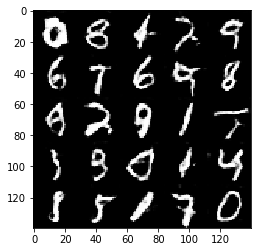

Epoch 2/2... Discriminator Loss: 0.8441... Generator Loss: 2.3498
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 0.6986
Epoch 2/2... Discriminator Loss: 1.0702... Generator Loss: 0.7556
Epoch 2/2... Discriminator Loss: 1.0113... Generator Loss: 1.0594
Epoch 2/2... Discriminator Loss: 0.7023... Generator Loss: 1.3058
Epoch 2/2... Discriminator Loss: 0.7012... Generator Loss: 1.1252
Epoch 2/2... Discriminator Loss: 0.9761... Generator Loss: 2.2127
Epoch 2/2... Discriminator Loss: 0.9870... Generator Loss: 1.0071
Epoch 2/2... Discriminator Loss: 1.5386... Generator Loss: 0.3784
Epoch 2/2... Discriminator Loss: 3.3948... Generator Loss: 5.2212


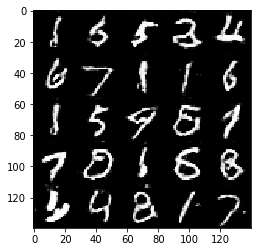

Epoch 2/2... Discriminator Loss: 1.0492... Generator Loss: 1.5425
Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 1.0132
Epoch 2/2... Discriminator Loss: 0.7540... Generator Loss: 1.0760
Epoch 2/2... Discriminator Loss: 1.7595... Generator Loss: 0.2880
Epoch 2/2... Discriminator Loss: 1.4885... Generator Loss: 0.4423
Epoch 2/2... Discriminator Loss: 0.9306... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 1.8395... Generator Loss: 0.2664


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1438... Generator Loss: 0.1735
Epoch 1/1... Discriminator Loss: 0.6434... Generator Loss: 12.7172
Epoch 1/1... Discriminator Loss: 3.3192... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 0.4195... Generator Loss: 5.4819
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 2.8946
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 0.3008... Generator Loss: 2.1654
Epoch 1/1... Discriminator Loss: 1.7364... Generator Loss: 0.2718
Epoch 1/1... Discriminator Loss: 0.1704... Generator Loss: 5.0803


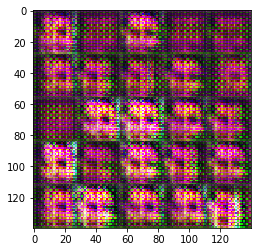

Epoch 1/1... Discriminator Loss: 0.3088... Generator Loss: 3.1024
Epoch 1/1... Discriminator Loss: 0.2346... Generator Loss: 2.3318
Epoch 1/1... Discriminator Loss: 0.2805... Generator Loss: 2.2988
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 0.2066... Generator Loss: 3.7042
Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 1.8550
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 6.4473
Epoch 1/1... Discriminator Loss: 0.1590... Generator Loss: 5.5420
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 1.9087


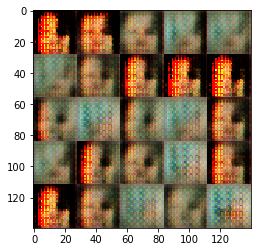

Epoch 1/1... Discriminator Loss: 0.2758... Generator Loss: 2.8411
Epoch 1/1... Discriminator Loss: 1.7803... Generator Loss: 0.2553
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.6659
Epoch 1/1... Discriminator Loss: 1.8567... Generator Loss: 0.3589
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 1.2631
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.4526
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 0.6800... Generator Loss: 2.5923
Epoch 1/1... Discriminator Loss: 0.4199... Generator Loss: 2.3901


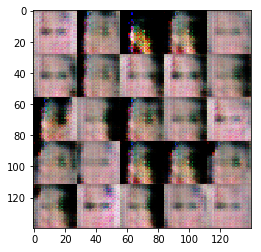

Epoch 1/1... Discriminator Loss: 2.1428... Generator Loss: 0.1593
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.0660
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 1.8345
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.9380


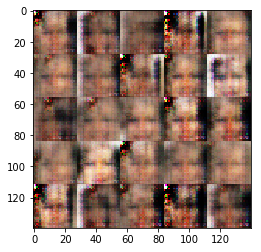

Epoch 1/1... Discriminator Loss: 1.8264... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 2.8523
Epoch 1/1... Discriminator Loss: 1.9887... Generator Loss: 3.4227
Epoch 1/1... Discriminator Loss: 3.4138... Generator Loss: 4.5212
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.4567


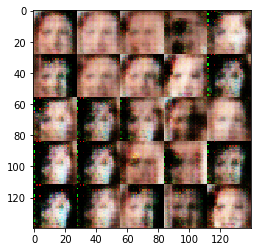

Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 1.5621
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.3504
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.7862... Generator Loss: 2.4131
Epoch 1/1... Discriminator Loss: 1.6559... Generator Loss: 0.3265
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 1.5809
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.6347
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.9816


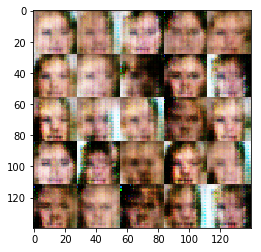

Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.1166
Epoch 1/1... Discriminator Loss: 1.8805... Generator Loss: 3.0401
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 1.5244
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.6339
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 1.9802
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.4470


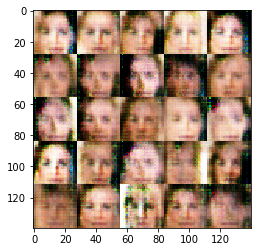

Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 0.5406... Generator Loss: 1.5993
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 2.5097
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.4382
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.4047
Epoch 1/1... Discriminator Loss: 2.8818... Generator Loss: 3.7336
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.7229


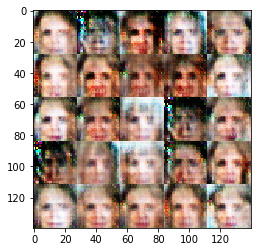

Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 3.6953
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.5204
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.1852
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 2.7548
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 1.8278
Epoch 1/1... Discriminator Loss: 1.6187... Generator Loss: 2.6232


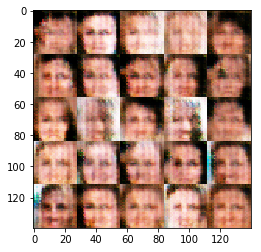

Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.3820
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.3754
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.8158
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 0.7624


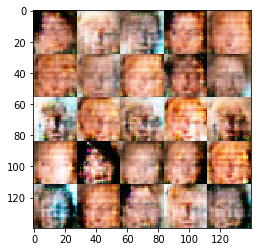

Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 2.0068
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 1.2658
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 1.6493
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.7227


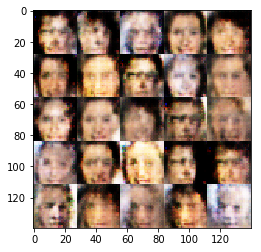

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.0532
Epoch 1/1... Discriminator Loss: 1.6741... Generator Loss: 2.4793
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.2628
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.6864


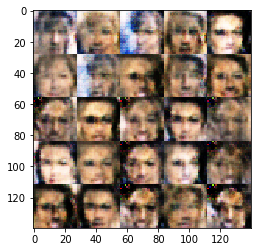

Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.2670
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.5478
Epoch 1/1... Discriminator Loss: 1.7099... Generator Loss: 0.2826
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.8937


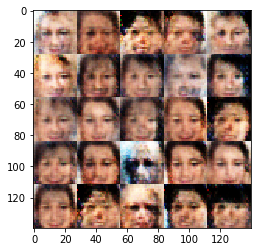

Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.6260
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.1801
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 1.3864


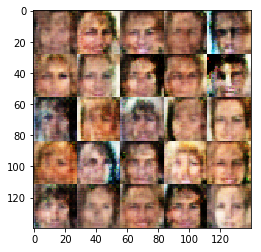

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 1.9405
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.6268
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 2.2021
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 1.8395
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.5381


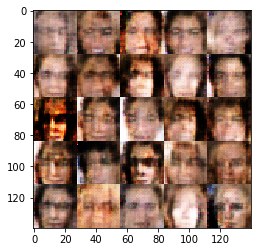

Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 1.4504
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.5121
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.6688


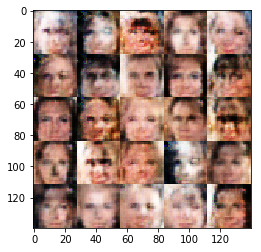

Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 1.6906
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.7610... Generator Loss: 0.2908


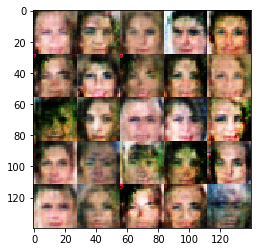

Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 1.4478
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.9506


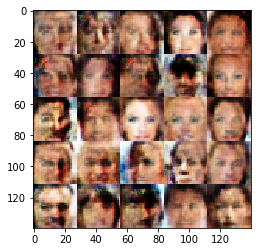

Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.3550
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.5783


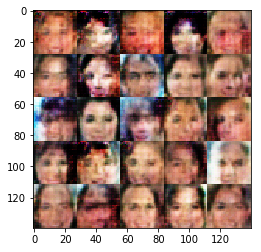

Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.2125
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.2492
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 1.8914
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.3690
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.8572


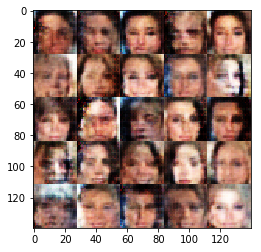

Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.2992
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 1.1678
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 1.5845
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 2.1193
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 2.0129
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.4858


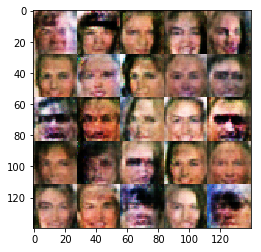

Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.8295... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.1433
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 1.5539
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.5029


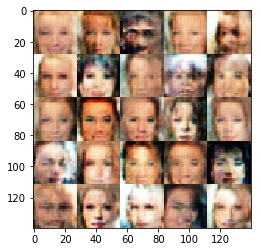

Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.4025
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.9743... Generator Loss: 1.9105
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.0491


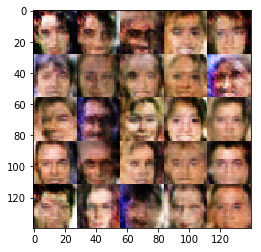

Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.1550
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.3119
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8861


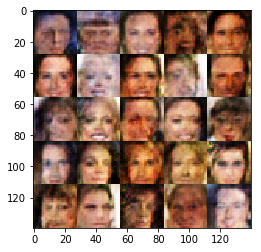

Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 1.4173
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 0.8005... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.1900


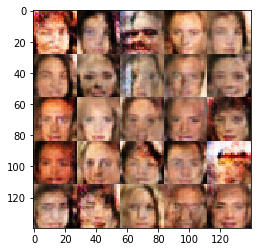

Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 1.4822
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 0.7794... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 0.9147


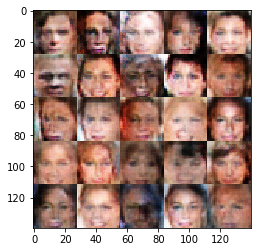

Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.3961
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.2949
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.7051


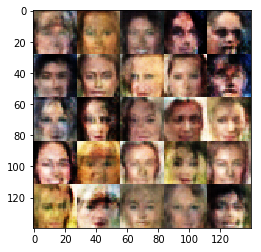

Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 1.1450
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.7960


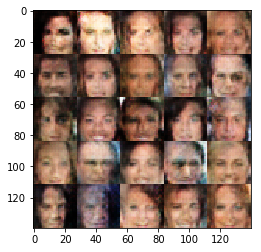

Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 1.2953
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.1104


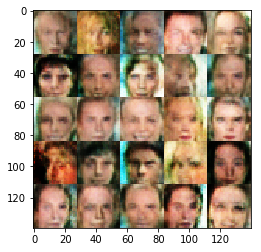

Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.3152
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.5168
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 1.3367


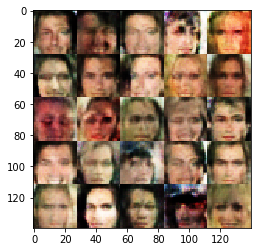

Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 0.3496
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.7669


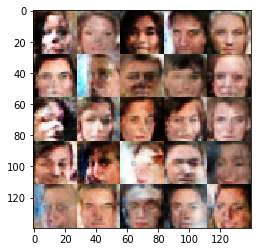

Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.2916
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 1.4743


In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.